<center>基于波函数的流体超分辨研究</center>

# 问题描述


传统的超分辨是给定图片a，经过超分辨能够得到精度更高的图片b

我们希望能够在超分辨模型前后进行结构的调整，使得其能够自适应涡旋流体超分辨，为方便后续研究，我们暂且将这个方法的名字成为$Clebsch$流体超分辨。

$Clebsch$流体超分辨分为四个步骤：
我们首先有一些流体的图片集，我们是能够已知其图片的结构的，即网格数据，和网格对应的速度场。
其次，我们能够知道双分量波函数是可以经过公式转换得到对应速度场的，双分量波函数形如$\psi = a+bi+cj+dk$

1. 从任意一张已知的图片出发，我们假设该图片是$128\times 128$，经过$model_A$后我们能够找到$a,b,c,d$，与之对应的，$a,b,c,d$每一个单独的量都应该是$128\times 128$

2. 我们将得到的$a,b,c,d$再经过一个$model_B$，这个$model_B$是一个超分辨模型，然后我们将得到对应的$a,b,c,d$，我们假设其分辨率从128提高到了256

3. 我们需要再训练一个从abcd到速度场的$model_c$，然后我们就能得到256的速度场了。

我们希望经过我们改进后的超分辨模型，能够更加适应用于涡旋的流体现象，因为我们能够chern的文章中验证通过波函数的方法能够较好的捕捉涡结构。

为了能够得到上面的模型，我们需要逐步训练各个部分模型，这项工作，只是进行一个简单的尝试，因此，我们会对采用精度较低的图片，以提高模型的训练速度，来验证本项工作的可行性。

# 初始案例构建

函数 \(a(x, y)\)、\(b(x, y)\)、\(c(x, y)\) 和 \(d(x, y)\) 定义如下：
\begin{align*}
    H(x) &= 
    \begin{cases} 
      \frac{x}{2} & \text{如果 } 0 \leq x \leq \pi \\
      \pi - \frac{x}{2} & \text{如果 } \pi < x \leq 2\pi 
    \end{cases} \\
    a(x, y) &= \cos[H(x)] \cos\left(\frac{\cos(y) (2 - \cos(x))}{\hbar}\right), \\
    b(x, y) &= \cos[H(x)] \sin\left(\frac{\cos(y) (2 - \cos(x))}{\hbar}\right), \\
    c(x, y) &= \sin[H(x)] \cos\left(\frac{\cos(y) (2 + \cos(x))}{\hbar}\right), \\
    d(x, y) &= -\sin[H(x)] \sin\left(\frac{\cos(y) (2 + \cos(x))}{\hbar}\right).
\end{align*}
其中，$\hbar $是一个常数（为了简化，设为1）。

速度场计算
$$
\mathbf{u} = \hbar(a \mathbf \nabla b-b\mathbf \nabla a + c\mathbf \nabla d - d\mathbf \nabla c)
$$

速度场分量 $u_x$ 和 $u_y$ 使用 $a$、$b$、$c$、$d$ 的梯度计算得到：
$$
\begin{align*}
    \nabla a &= \left(\frac{\partial a}{\partial x}, \frac{\partial a}{\partial y}\right), \\
    \nabla b &= \left(\frac{\partial b}{\partial x}, \frac{\partial b}{\partial y}\right), \\
    \nabla c &= \left(\frac{\partial c}{\partial x}, \frac{\partial c}{\partial y}\right), \\
    \nabla d &= \left(\frac{\partial d}{\partial x}, \frac{\partial d}{\partial y}\right).
\end{align*}
$$

速度场的计算公式为：
\begin{align*}
    u_x &= \hbar \left(a \frac{\partial b}{\partial x} - b \frac{\partial a}{\partial x} + c \frac{\partial d}{\partial x} - d \frac{\partial c}{\partial x}\right), \\
    u_y &= \hbar \left(a \frac{\partial b}{\partial y} - b \frac{\partial a}{\partial y} + c \frac{\partial d}{\partial y} - d \frac{\partial c}{\partial y}\right).
\end{align*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# 定义常数
hbar = 1

# 定义 H(x)
def H(x):
    return np.where((0 <= x) & (x <= np.pi), x / 2, np.pi - x / 2)

# 定义函数 a, b, c, d
def a(x, y):
    return np.cos(H(x)) * np.cos(np.cos(y) * (2 - np.cos(x)) / hbar)

def b(x, y):
    return np.cos(H(x)) * np.sin(np.cos(y) * (2 - np.cos(x)) / hbar)

def c(x, y):
    return np.sin(H(x)) * np.cos(np.cos(y) * (2 + np.cos(x)) / hbar)

def d(x, y):
    return -np.sin(H(x)) * np.sin(np.cos(y) * (2 + np.cos(x)) / hbar)

# 计算梯度1
def gradient(f, x, y, eps=1e-5):
    f_x = (f(x + eps, y) - f(x - eps, y)) / (2 * eps)
    f_y = (f(x, y + eps) - f(x, y - eps)) / (2 * eps)
    return f_x, f_y

# 计算速度场
def compute_velocity_field_np(x, y, dx, dy):
    # 使用内置的np 求解梯度
    a_val = a(x, y)
    b_val = b(x, y)
    c_val = c(x, y)
    d_val = d(x, y)

    a_grad_x, a_grad_y = np.gradient(a_val, dx, dy)
    b_grad_x, b_grad_y = np.gradient(b_val, dx, dy)
    c_grad_x, c_grad_y = np.gradient(c_val, dx, dy)
    d_grad_x, d_grad_y = np.gradient(d_val, dx, dy)

    u_x = hbar * (a_val * b_grad_x - b_val * a_grad_x + c_val * d_grad_x - d_val * c_grad_x)
    u_y = hbar * (a_val * b_grad_y - b_val * a_grad_y + c_val * d_grad_y - d_val * c_grad_y)

    return u_x, u_y

def compute_velocity_field_FD(x, y):
    # 有限差分进行计算
    a_val = a(x, y)
    b_val = b(x, y)
    c_val = c(x, y)
    d_val = d(x, y)

    a_grad_x, a_grad_y = gradient(a, x, y)
    b_grad_x, b_grad_y = gradient(b, x, y)
    c_grad_x, c_grad_y = gradient(c, x, y)
    d_grad_x, d_grad_y = gradient(d, x, y)

    u_x = hbar * (a_val * b_grad_x - b_val * a_grad_x + c_val * d_grad_x - d_val * c_grad_x)
    u_y = hbar * (a_val * b_grad_y - b_val * a_grad_y + c_val * d_grad_y - d_val * c_grad_y)

    return u_x, u_y

In [3]:
size = 128
x = np.linspace(0, 2 * np.pi, size)
y = np.linspace(0, 2 * np.pi, size)
X, Y = np.meshgrid(x, y)

In [4]:
# 计算步长
dx = x[1] - x[0]
dy = y[1] - y[0]

In [5]:
U_x, U_y = compute_velocity_field_np(X, Y, dx, dy)

U_x_FD, U_y_FD = compute_velocity_field_FD(X, Y)

# 计算速度场的大小
U_magnitude = np.sqrt(U_x**2 + U_y**2)

U_magnitude_FD = np.sqrt(U_x_FD**2 + U_y_FD**2)

## 可视化速度场

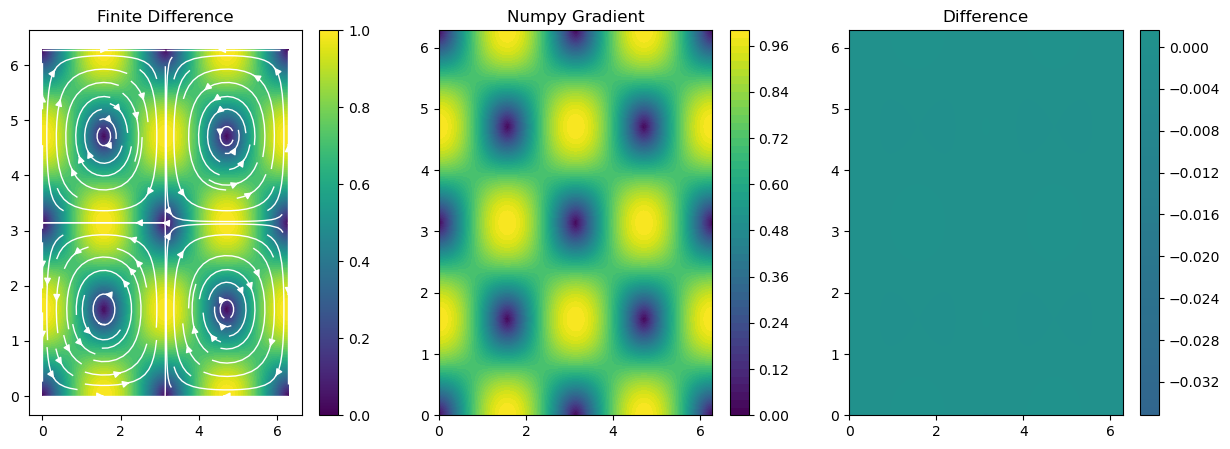

In [6]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.contourf(X, Y, U_magnitude_FD, levels=50, cmap='viridis')
plt.streamplot(X, Y, U_x_FD, U_y_FD, color='white', linewidth=1)
plt.title('Finite Difference')
plt.colorbar()


plt.subplot(1,3,2)
plt.contourf(X, Y, U_magnitude, levels=50, cmap='viridis')
# plt.streamplot(X, Y, U_x, U_y, color='white', linewidth=1)
plt.title('Numpy Gradient')
plt.colorbar()


plt.subplot(1,3,3)
plt.contourf(X, Y, U_magnitude_FD-U_magnitude, levels=50, cmap='viridis', vmin=-0.1, vmax=0.1)
plt.title('Difference')
plt.colorbar()

plt.show()


## 可视化涡量场

In [7]:
# 计算旋度
def vorticity(U_x, U_y, dx, dy):
    dU_y_dx, _ = np.gradient(U_y, dx, axis=0), np.gradient(U_y, dy, axis=1)
    _, dU_x_dy = np.gradient(U_x, dx, axis=0), np.gradient(U_x, dy, axis=1)
    return dU_y_dx - dU_x_dy

In [8]:
# 计算旋度
vort = vorticity(U_x, U_y, dx, dy)
vort_FD = vorticity(U_x_FD, U_y_FD, dx, dy)

# 归一化旋度
max_vort = np.max(np.abs(vort))
vort_normalized = vort / max_vort if max_vort != 0 else vort

max_vort_FD = np.max(np.abs(vort_FD))
vort_normalized_FD = vort_FD / max_vort_FD if max_vort_FD != 0 else vort_FD



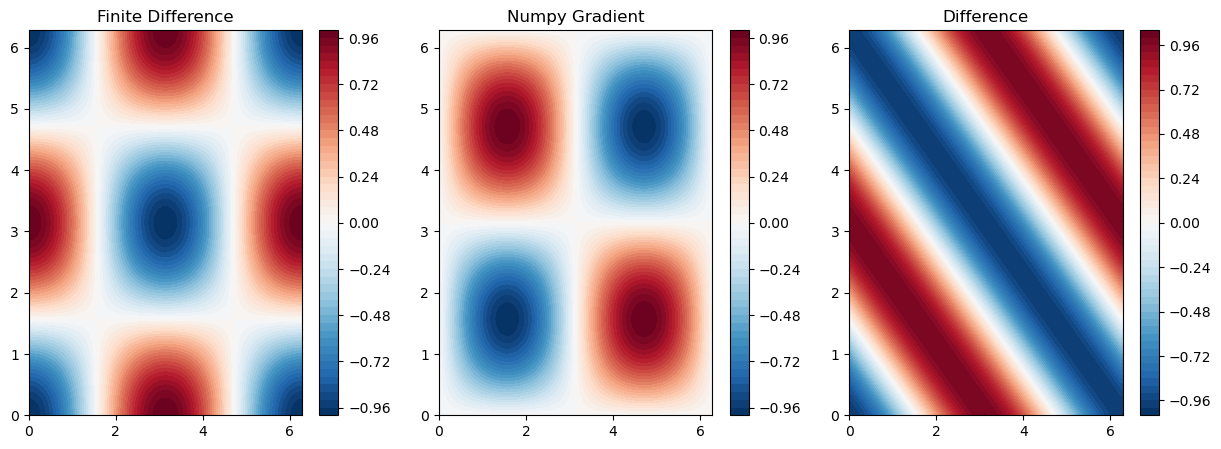

In [9]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.contourf(X, Y, vort_normalized_FD, levels=50, cmap='RdBu_r')
plt.title('Finite Difference')
plt.colorbar()

plt.subplot(1,3,2)
plt.contourf(X, Y, vort_normalized, levels=50, cmap='RdBu_r')
plt.title('Numpy Gradient')
plt.colorbar()

plt.subplot(1,3,3)
plt.contourf(X, Y, vort_normalized_FD-vort_normalized, levels=50, cmap='RdBu_r')
plt.title('Difference')
plt.colorbar()

plt.show()

从这个结果看，我们采用np的内置梯度求导函数的结果与Zhaoyuan Meng(2023)的文章从视觉上看是一直的，而采用有限差分的求梯度似乎存在一定的问题，这个问题，在有np内置梯度函数的情况下，目前不太影响我们的模型，因此，我们当前先记录下这个问题，继续进行后续模型的训练。


根据上述文中代码所属，我们最后选择是：
1. 速度变量的分量是：`U_x, U_y, U_magnitude`
2. 归一化后的涡量是：`vort_normalized`

# $model_A$训练

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [11]:
# 将数据转换为PyTorch张量
U_x = torch.tensor(U_x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # 增加batch和channel维度
U_y = torch.tensor(U_y, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
U_magnitude = torch.tensor(U_magnitude, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# 合并速度场作为输入
velocity_field = torch.cat((U_x, U_y, U_magnitude), dim=1)

# 目标abcd (假设为0初始化)
target_abcd = torch.zeros((1, 4, size, size), dtype=torch.float32)

# 创建数据集和数据加载器
dataset = TensorDataset(velocity_field, target_abcd)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [12]:
# 定义模型A
class ModelA(nn.Module):
    def __init__(self):
        super(ModelA, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 4, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)  # 不使用激活函数，让输出保留原始值范围
        return x

In [13]:
# 定义损失函数
def loss_function(predicted_abcd, true_velocity, epsilon):
    # 提取 a, b, c, d
    a = predicted_abcd[:, 0, :, :]
    b = predicted_abcd[:, 1, :, :]
    c = predicted_abcd[:, 2, :, :]
    d = predicted_abcd[:, 3, :, :]

    # 根据 a, b, c, d 计算预测的速度场
    U_x_pred = a + b
    U_y_pred = c + d
    U_magnitude_pred = torch.sqrt(U_x_pred**2 + U_y_pred**2)
    
    # 计算速度场的损失
    U_x_true = true_velocity[:, 0, :, :]
    U_y_true = true_velocity[:, 1, :, :]
    U_magnitude_true = true_velocity[:, 2, :, :]
    
    loss_velocity = F.mse_loss(U_x_pred, U_x_true) + F.mse_loss(U_y_pred, U_y_true) + F.mse_loss(U_magnitude_pred, U_magnitude_true)
    
    # 计算正则化项
    regularization_term = epsilon * (torch.sum(a**2) + torch.sum(b**2) + torch.sum(c**2) + torch.sum(d**2))
    
    # 总损失
    total_loss = loss_velocity + regularization_term
    return total_loss


In [14]:
# 超参数
learning_rate = 0.001
num_epochs = 10000
epsilon = 0.01

# 创建模型和优化器
model = ModelA()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [15]:
# 训练模型
for epoch in range(num_epochs):
    for i, (velocity, _) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_abcd = model(velocity)
        loss = loss_function(predicted_abcd, velocity, epsilon)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')


Epoch [1/10000], Step [1], Loss: 1.2642
Epoch [2/10000], Step [1], Loss: 26.3785
Epoch [3/10000], Step [1], Loss: 2.1757
Epoch [4/10000], Step [1], Loss: 1.0347
Epoch [5/10000], Step [1], Loss: 1.1759
Epoch [6/10000], Step [1], Loss: 1.1844
Epoch [7/10000], Step [1], Loss: 1.1229
Epoch [8/10000], Step [1], Loss: 1.0607
Epoch [9/10000], Step [1], Loss: 1.0186
Epoch [10/10000], Step [1], Loss: 1.0103
Epoch [11/10000], Step [1], Loss: 1.0174
Epoch [12/10000], Step [1], Loss: 1.0136
Epoch [13/10000], Step [1], Loss: 1.0000
Epoch [14/10000], Step [1], Loss: 0.9922
Epoch [15/10000], Step [1], Loss: 0.9962
Epoch [16/10000], Step [1], Loss: 0.9980
Epoch [17/10000], Step [1], Loss: 0.9938
Epoch [18/10000], Step [1], Loss: 0.9900
Epoch [19/10000], Step [1], Loss: 0.9865
Epoch [20/10000], Step [1], Loss: 0.9837
Epoch [21/10000], Step [1], Loss: 0.9829
Epoch [22/10000], Step [1], Loss: 0.9833
Epoch [23/10000], Step [1], Loss: 0.9832
Epoch [24/10000], Step [1], Loss: 0.9821
Epoch [25/10000], Step [

In [16]:
# 测试数据生成
U_x_test, U_y_test = compute_velocity_field_np(X, Y, dx, dy)
U_magnitude_test = np.sqrt(U_x_test**2 + U_y_test**2)

# 将测试数据转换为PyTorch张量
U_x_test = torch.tensor(U_x_test, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
U_y_test = torch.tensor(U_y_test, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
U_magnitude_test = torch.tensor(U_magnitude_test, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# 合并测试速度场作为输入
velocity_field_test = torch.cat((U_x_test, U_y_test, U_magnitude_test), dim=1)

# 将模型设置为评估模式
model.eval()

# 使用测试数据进行预测
with torch.no_grad():
    predicted_abcd_test = model(velocity_field_test)

# 打印预测结果
print("Predicted a, b, c, d:")
print(predicted_abcd_test)

# 计算预测的速度场
a_test = predicted_abcd_test[:, 0, :, :].squeeze().numpy()
b_test = predicted_abcd_test[:, 1, :, :].squeeze().numpy()
c_test = predicted_abcd_test[:, 2, :, :].squeeze().numpy()
d_test = predicted_abcd_test[:, 3, :, :].squeeze().numpy()

U_x_pred_test = a_test + b_test
U_y_pred_test = c_test + d_test
U_magnitude_pred_test = np.sqrt(U_x_pred_test**2 + U_y_pred_test**2)

Predicted a, b, c, d:
tensor([[[[-0.0003, -0.0004, -0.0004,  ..., -0.0003, -0.0003, -0.0003],
          [-0.0007, -0.0006, -0.0007,  ..., -0.0006, -0.0007, -0.0007],
          [-0.0011, -0.0013, -0.0012,  ..., -0.0011, -0.0012, -0.0012],
          ...,
          [ 0.0011,  0.0011,  0.0010,  ...,  0.0011,  0.0012,  0.0010],
          [ 0.0005,  0.0005,  0.0006,  ...,  0.0006,  0.0005,  0.0006],
          [ 0.0002,  0.0002,  0.0002,  ...,  0.0003,  0.0002,  0.0003]],

         [[-0.0004, -0.0004, -0.0004,  ..., -0.0003, -0.0004, -0.0004],
          [-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0006],
          [-0.0013, -0.0013, -0.0012,  ..., -0.0013, -0.0013, -0.0013],
          ...,
          [ 0.0011,  0.0010,  0.0010,  ...,  0.0011,  0.0011,  0.0012],
          [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
          [ 0.0002,  0.0002,  0.0002,  ...,  0.0003,  0.0002,  0.0003]],

         [[ 0.0003,  0.0005,  0.0012,  ..., -0.0012, -0.0006, -0.0003],
        

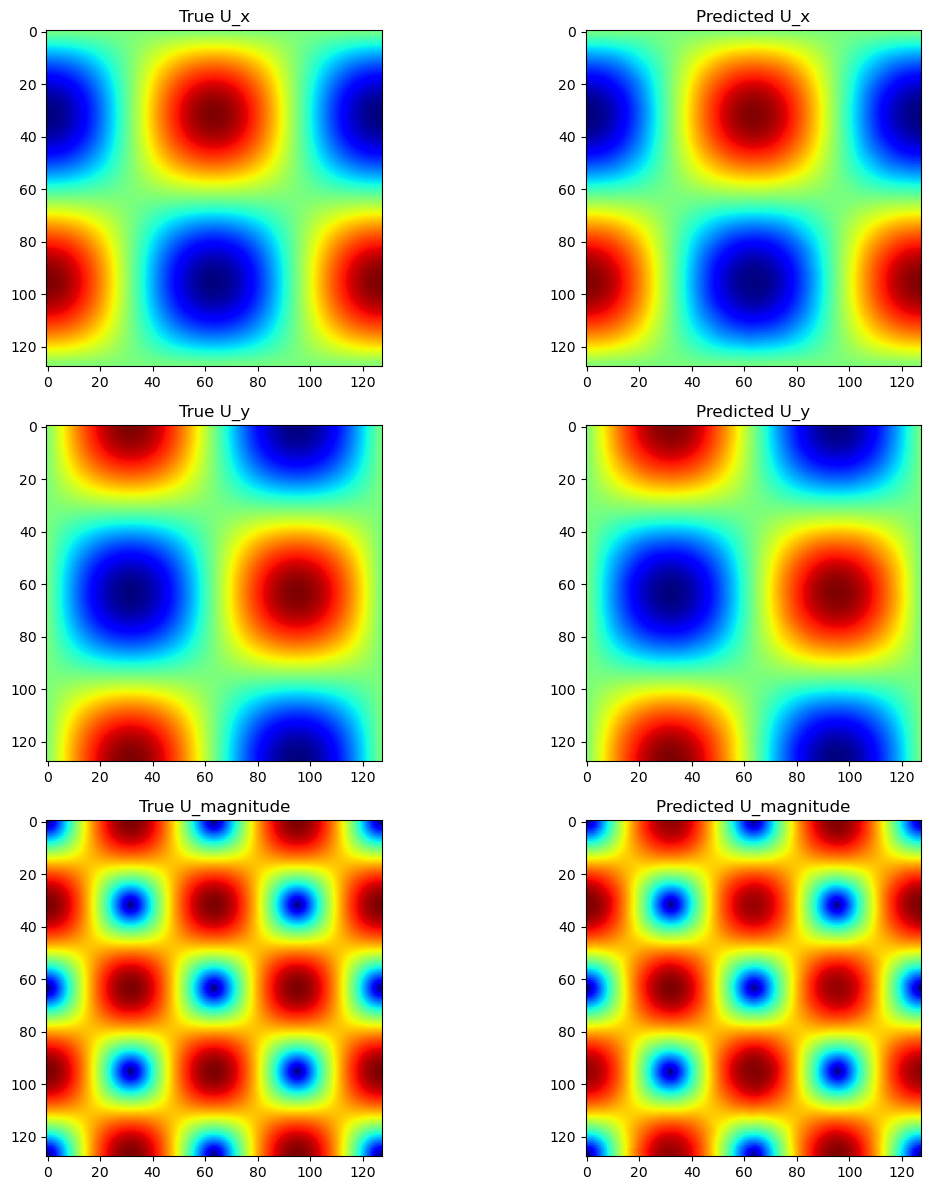

In [17]:
# 绘图
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# U_x
axes[0, 0].imshow(U_x_test.squeeze().numpy(), cmap='jet')
axes[0, 0].set_title('True U_x')
axes[0, 1].imshow(U_x_pred_test, cmap='jet')
axes[0, 1].set_title('Predicted U_x')

# U_y
axes[1, 0].imshow(U_y_test.squeeze().numpy(), cmap='jet')
axes[1, 0].set_title('True U_y')
axes[1, 1].imshow(U_y_pred_test, cmap='jet')
axes[1, 1].set_title('Predicted U_y')

# U_magnitude
axes[2, 0].imshow(U_magnitude_test.squeeze().numpy(), cmap='jet')
axes[2, 0].set_title('True U_magnitude')
axes[2, 1].imshow(U_magnitude_pred_test, cmap='jet')
axes[2, 1].set_title('Predicted U_magnitude')

plt.tight_layout()
plt.show()


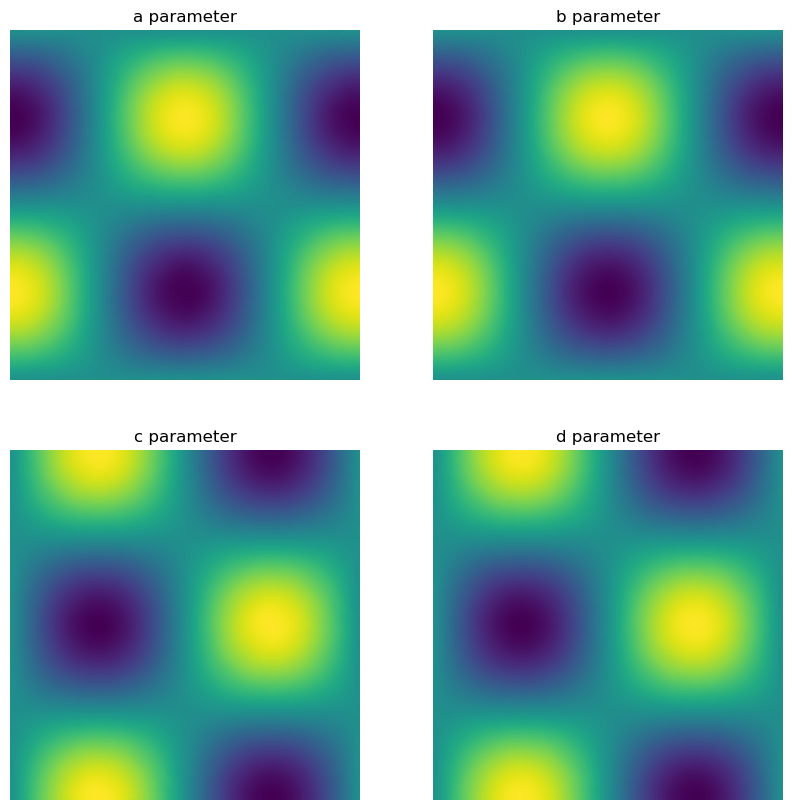

In [18]:
import matplotlib.pyplot as plt

# 计算预测的速度场
a_test = predicted_abcd_test[:, 0, :, :].squeeze().numpy()
b_test = predicted_abcd_test[:, 1, :, :].squeeze().numpy()
c_test = predicted_abcd_test[:, 2, :, :].squeeze().numpy()
d_test = predicted_abcd_test[:, 3, :, :].squeeze().numpy()

# 创建图形窗口
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# 可视化a参数
axs[0, 0].imshow(a_test, cmap='viridis')
axs[0, 0].set_title('a parameter')
axs[0, 0].axis('off')

# 可视化b参数
axs[0, 1].imshow(b_test, cmap='viridis')
axs[0, 1].set_title('b parameter')
axs[0, 1].axis('off')

# 可视化c参数
axs[1, 0].imshow(c_test, cmap='viridis')
axs[1, 0].set_title('c parameter')
axs[1, 0].axis('off')

# 可视化d参数
axs[1, 1].imshow(d_test, cmap='viridis')
axs[1, 1].set_title('d parameter')
axs[1, 1].axis('off')

# 显示图形
plt.show()


## 模型A训练


In [ ]:
class WaveFunctionModel(nn.Module):
    def __init__(self):
        super(WaveFunctionModel, self).__init__()
        # 定义模型的卷积层和池化层
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 max pooling
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # 使用适当尺寸的全连接层
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # 假设输入尺寸为128x128，经过3次2x2池化后变为16x16
        self.fc2 = nn.Linear(512, 4 * 128 * 128)  # 输出尺寸为4x128x128
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)  # 最后一次池化后，尺寸变为8x8
        
        x = x.view(-1, 128 * 8 * 8)  # 展平成一维
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 4, 128, 128)  # 恢复为4个通道的128x128的输出
        return x


In [ ]:
# 计算梯度
def compute_gradient(f):
    f_grad_x = torch.gradient(f, dim=2)[0]  # 对 x 方向的梯度
    f_grad_y = torch.gradient(f, dim=1)[0]  # 对 y 方向的梯度
    return f_grad_x, f_grad_y

# 计算拉普拉斯算子
def laplacian(f):
    f_grad_x, f_grad_y = compute_gradient(f)
    f_laplace = torch.gradient(f_grad_x, dim=2)[0] + torch.gradient(f_grad_y, dim=1)[0]
    return f_laplace

# 损失函数
def loss_function(output_abcd, u_given, hbar=1):
    mse_loss = nn.MSELoss()
    
    a, b, c, d = output_abcd[:, 0, :, :], output_abcd[:, 1, :, :], output_abcd[:, 2, :, :], output_abcd[:, 3, :, :]
    da_dx, da_dy = compute_gradient(a)
    db_dx, db_dy = compute_gradient(b)
    dc_dx, dc_dy = compute_gradient(c)
    dd_dx, dd_dy = compute_gradient(d)
    
    u_pre_x = hbar * (a * db_dx - b * da_dx + c * dd_dx - d * dc_dx)
    u_pre_y = hbar * (a * db_dy - b * da_dy + c * dd_dy - d * dc_dy)
    
    # 打印调试信息
    # print(f'u_pre_x shape: {u_pre_x.shape}')
    # print(f'u_given shape: {u_given.shape}')
    
    # 确保 u_given 的维度正确
    if u_given.shape[1] == 1:
        velocity_loss = mse_loss(u_pre_x, u_given[:, 0, :, :])
    else:
        velocity_loss = mse_loss(u_pre_x, u_given[:, 0, :, :]) + mse_loss(u_pre_y, u_given[:, 1, :, :])
    
    # 规范化约束损失
    normalization_loss = torch.mean(a**2 + b**2 + c**2 + d**2) - 1
    
    # 散度约束损失
    lap_a = laplacian(a)
    lap_b = laplacian(b)
    lap_c = laplacian(c)
    lap_d = laplacian(d)
    solenoidal_loss = torch.mean(lap_a * b - a * lap_b + lap_c * d - c * lap_d)
    
    total_loss = velocity_loss + normalization_loss**2 + solenoidal_loss**2
    return total_loss


In [ ]:
# 生成训练数据
def generate_data(size=128, num_samples=1000):
    x = np.linspace(0, 2 * np.pi, size)
    y = np.linspace(0, 2 * np.pi, size)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    X, Y = np.meshgrid(x, y)

    images = []
    velocity_fields = []

    for _ in range(num_samples):
        # 计算波函数参数和速度场
        U_x, U_y = compute_velocity_field_np(X, Y, dx, dy)
        U_magnitude = np.sqrt(U_x**2 + U_y**2)

        # 生成随机噪声图像，模拟流体图片（这里可以替换为真实流体图片）
        image = np.random.rand(size, size)

        # 添加数据到列表
        images.append(image)
        velocity_fields.append(U_magnitude)

    images = np.array(images)
    velocity_fields = np.array(velocity_fields)

    return images, velocity_fields

In [ ]:
# 生成训练数据
images, velocity_fields = generate_data(size=128, num_samples=1000)

# 转换为 PyTorch 张量
images_tensor = torch.tensor(images, dtype=torch.float32).unsqueeze(1)  # 添加通道维度
velocity_fields_tensor = torch.tensor(velocity_fields, dtype=torch.float32).unsqueeze(1)  # 添加通道维度

# 创建数据集和数据加载器
dataset = TensorDataset(images_tensor, velocity_fields_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
# 示例训练步骤
model = WaveFunctionModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10


In [ ]:
for epoch in range(num_epochs):
    model.train()
    for batch_images, batch_velocity_fields in dataloader:
        optimizer.zero_grad()
        output_abcd = model(batch_images)
        loss = loss_function(output_abcd, batch_velocity_fields)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/10, Loss: 0.024283595383167267
Epoch 2/10, Loss: 0.004272181540727615
Epoch 3/10, Loss: 0.000396382762119174
Epoch 4/10, Loss: 7.285421452252194e-05
Epoch 5/10, Loss: 5.302077261148952e-05
Epoch 6/10, Loss: 4.0761213313089684e-05
Epoch 7/10, Loss: 5.9955145843559876e-05
Epoch 8/10, Loss: 3.723524423548952e-05
Epoch 9/10, Loss: 1.7770385966286995e-05
Epoch 10/10, Loss: 1.3671497981704306e-05


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 假设我们有一个生成测试数据的函数，类似于生成训练数据
def generate_test_data(size=128, num_samples=100):
    x = np.linspace(0, 2 * np.pi, size)
    y = np.linspace(0, 2 * np.pi, size)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    X, Y = np.meshgrid(x, y)

    images = []
    velocity_fields = []

    for _ in range(num_samples):
        # 计算波函数参数和速度场
        U_x, U_y = compute_velocity_field_np(X, Y, dx, dy)
        U_magnitude = np.sqrt(U_x**2 + U_y**2)

        # 生成随机噪声图像，模拟流体图片（这里可以替换为真实流体图片）
        image = np.random.rand(size, size)

        # 添加数据到列表
        images.append(image)
        velocity_fields.append(U_magnitude)

    images = np.array(images)
    velocity_fields = np.array(velocity_fields)

    return images, velocity_fields

# 生成测试数据
test_images, test_velocity_fields = generate_test_data(size=128, num_samples=100)

# 转换为 PyTorch 张量
test_images_tensor = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1)  # 添加通道维度
test_velocity_fields_tensor = torch.tensor(test_velocity_fields, dtype=torch.float32).unsqueeze(1)  # 添加通道维度

# 使用 DataLoader 加载测试数据
test_dataset = TensorDataset(test_images_tensor, test_velocity_fields_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 设置模型为评估模式
model.eval()

# 存储预测结果和实际值
predicted_velocity_fields = []
actual_velocity_fields = []

with torch.no_grad():
    for batch_images, batch_velocity_fields in test_dataloader:
        output_abcd = model(batch_images)
        
        # 计算预测的速度场
        a, b, c, d = output_abcd[:, 0, :, :], output_abcd[:, 1, :, :], output_abcd[:, 2, :, :], output_abcd[:, 3, :, :]
        da_dx, da_dy = compute_gradient(a)
        db_dx, db_dy = compute_gradient(b)
        dc_dx, dc_dy = compute_gradient(c)
        dd_dx, dd_dy = compute_gradient(d)
        
        u_pre_x = hbar * (a * db_dx - b * da_dx + c * dd_dx - d * dc_dx)
        u_pre_y = hbar * (a * db_dy - b * da_dy + c * dd_dy - d * dc_dy)
        u_pre_magnitude = torch.sqrt(u_pre_x**2 + u_pre_y**2)

        predicted_velocity_fields.append(u_pre_magnitude.cpu().numpy())
        actual_velocity_fields.append(batch_velocity_fields.cpu().numpy())

# 转换结果为 numpy 数组
predicted_velocity_fields = np.concatenate(predicted_velocity_fields, axis=0)
actual_velocity_fields = np.concatenate(actual_velocity_fields, axis=0)

# 计算误差指标，例如均方误差（MSE）
mse = np.mean((predicted_velocity_fields - actual_velocity_fields) ** 2)
print(f'Test MSE: {mse}')



0


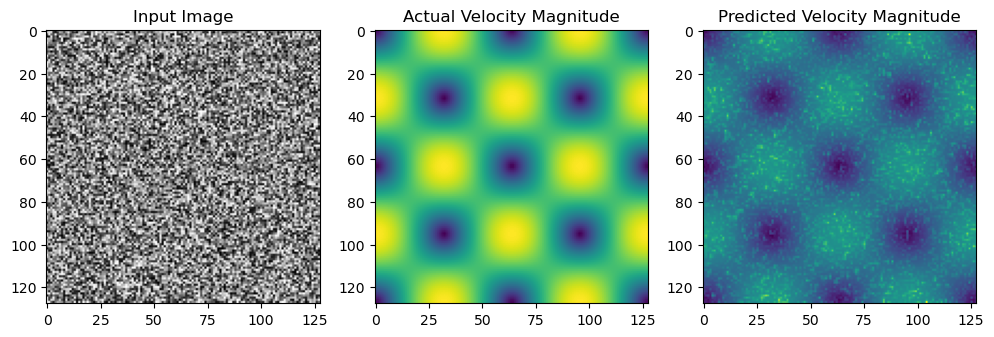

1


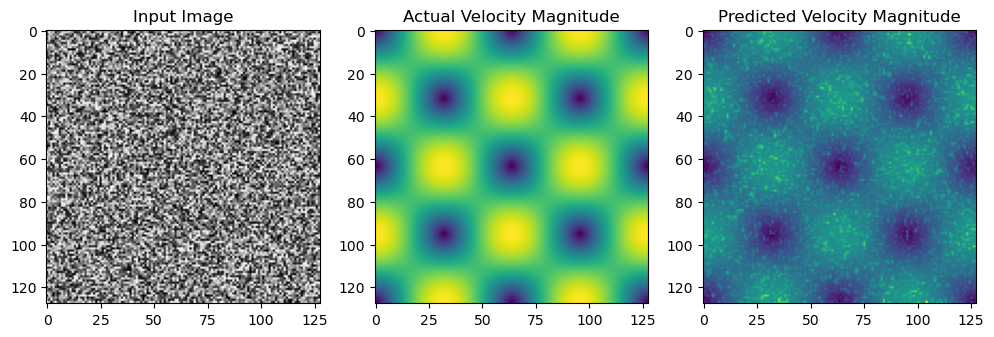

2


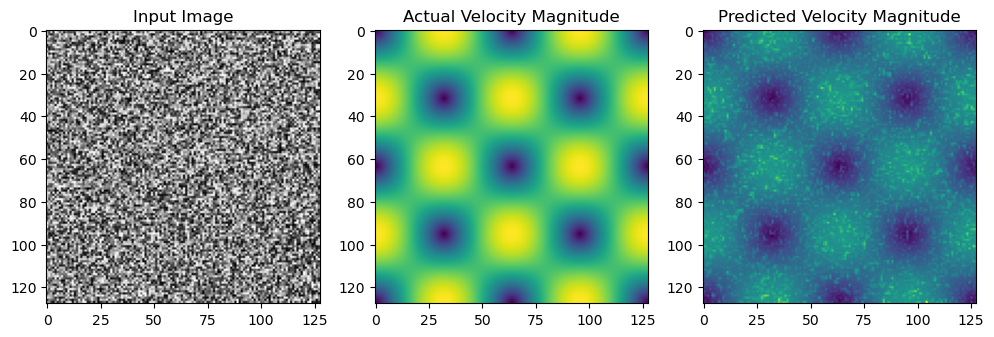

3


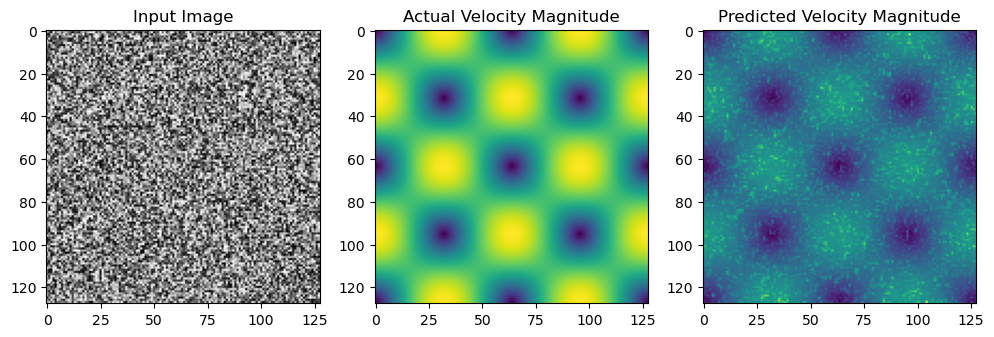

4


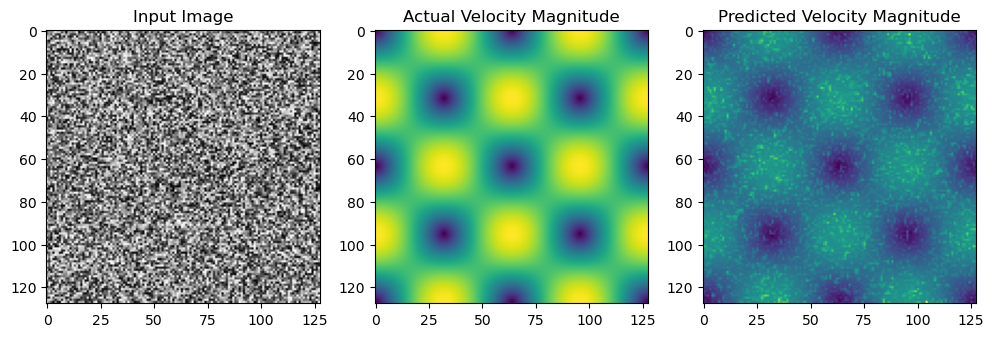

In [ ]:
# 可视化部分结果
num_samples_to_plot = 5
for i in range(num_samples_to_plot):
    print(i)
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(test_images[i], cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title('Actual Velocity Magnitude')
    plt.imshow(actual_velocity_fields[i, 0], cmap='viridis')
    
    plt.subplot(1, 3, 3)
    plt.title('Predicted Velocity Magnitude')
    plt.imshow(predicted_velocity_fields[i], cmap='viridis')
    
    plt.show()


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# 定义常数
hbar = 1

# 定义 H(x)
def H(x):
    return np.where((0 <= x) & (x <= np.pi), x / 2, np.pi - x / 2)

# 定义函数 a, b, c, d
def a(x, y):
    return np.cos(H(x)) * np.cos(np.cos(y) * (2 - np.cos(x)) / hbar)

def b(x, y):
    return np.cos(H(x)) * np.sin(np.cos(y) * (2 - np.cos(x)) / hbar)

def c(x, y):
    return np.sin(H(x)) * np.cos(np.cos(y) * (2 + np.cos(x)) / hbar)

def d(x, y):
    return -np.sin(H(x)) * np.sin(np.cos(y) * (2 + np.cos(x)) / hbar)

# 计算速度场
def compute_velocity_field_np(x, y, dx, dy):
    a_val = a(x, y)
    b_val = b(x, y)
    c_val = c(x, y)
    d_val = d(x, y)

    a_grad_x, a_grad_y = np.gradient(a_val, dx, dy)
    b_grad_x, b_grad_y = np.gradient(b_val, dx, dy)
    c_grad_x, c_grad_y = np.gradient(c_val, dx, dy)
    d_grad_x, d_grad_y = np.gradient(d_val, dx, dy)

    u_x = hbar * (a_val * b_grad_x - b_val * a_grad_x + c_val * d_grad_x - d_val * c_grad_x)
    u_y = hbar * (a_val * b_grad_y - b_val * a_grad_y + c_val * d_grad_y - d_val * c_grad_y)

    return u_x, u_y



In [ ]:
# 生成训练数据
def generate_training_data(size=128, num_samples=1000):
    x = np.linspace(0, 2 * np.pi, size)
    y = np.linspace(0, 2 * np.pi, size)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    X, Y = np.meshgrid(x, y)

    velocity_fields = []
    velocity_magnitudes = []

    for _ in range(num_samples):
        # 计算速度场
        U_x, U_y = compute_velocity_field_np(X, Y, dx, dy)
        U_magnitude = np.sqrt(U_x**2 + U_y**2)

        # 使用速度场作为输入
        velocity_field = np.stack([U_x, U_y], axis=0)
        velocity_fields.append(velocity_field)
        velocity_magnitudes.append(U_magnitude)

    velocity_fields = np.array(velocity_fields)
    velocity_magnitudes = np.array(velocity_magnitudes)

    return velocity_fields, velocity_magnitudes


In [ ]:

# 生成训练数据
velocity_fields, velocity_magnitudes = generate_training_data(size=128, num_samples=1000)

# 转换为 PyTorch 张量
velocity_fields_tensor = torch.tensor(velocity_fields, dtype=torch.float32)
velocity_magnitudes_tensor = torch.tensor(velocity_magnitudes, dtype=torch.float32).unsqueeze(1)  # 添加通道维度

# 创建数据集和数据加载器
dataset = TensorDataset(velocity_fields_tensor, velocity_magnitudes_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
# 定义改进的模型架构
class ImprovedWaveFunctionModel(nn.Module):
    def __init__(self):
        super(ImprovedWaveFunctionModel, self).__init__()
        # 增加模型的层数和复杂度
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)  # 输入通道改为2，表示 U_x 和 U_y
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)  # 假设输入尺寸为128x128，经过3次2x2池化后变为16x16
        self.fc2 = nn.Linear(1024, 4 * 128 * 128)  # 输出尺寸为4x128x128
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = x.view(-1, 256 * 8 * 8)  # 展平成一维
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 4, 128, 128)  # 恢复为4个通道的128x128的输出
        return x

In [ ]:
# 重新定义模型并进行训练
model = ImprovedWaveFunctionModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    for batch_velocity_fields, batch_velocity_magnitudes in dataloader:
        optimizer.zero_grad()
        output_abcd = model(batch_velocity_fields)
        loss = loss_function(output_abcd, batch_velocity_magnitudes)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')



In [ ]:
# 生成测试数据
test_velocity_fields, test_velocity_magnitudes = generate_training_data(size=128, num_samples=100)

# 转换为 PyTorch 张量
test_velocity_fields_tensor = torch.tensor(test_velocity_fields, dtype=torch.float32)
test_velocity_magnitudes_tensor = torch.tensor(test_velocity_magnitudes, dtype=torch.float32).unsqueeze(1)  # 添加通道维度

# 使用 DataLoader 加载测试数据
test_dataset = TensorDataset(test_velocity_fields_tensor, test_velocity_magnitudes_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 设置模型为评估模式
model.eval()

# 存储预测结果和实际值
predicted_velocity_fields = []
actual_velocity_fields = []


In [ ]:
with torch.no_grad():
    for batch_velocity_fields, batch_velocity_magnitudes in test_dataloader:
        output_abcd = model(batch_velocity_fields)
        
        # 计算预测的速度场
        a, b, c, d = output_abcd[:, 0, :, :], output_abcd[:, 1, :, :], output_abcd[:, 2, :, :], output_abcd[:, 3, :, :]
        da_dx, da_dy = compute_gradient(a)
        db_dx, db_dy = compute_gradient(b)
        dc_dx, dc_dy = compute_gradient(c)
        dd_dx, dd_dy = compute_gradient(d)
        
        u_pre_x = hbar * (a * db_dx - b * da_dx + c * dd_dx - d * dc_dx)
        u_pre_y = hbar * (a * db_dy - b * da_dy + c * dd_dy - d * dc_dy)
        u_pre_magnitude = torch.sqrt(u_pre_x**2 + u_pre_y**2)

        predicted_velocity_fields.append(u_pre_magnitude.cpu().numpy())
        actual_velocity_fields.append(batch_velocity_magnitudes.cpu().numpy())


In [ ]:
# 转换结果为 numpy 数组
predicted_velocity_fields = np.concatenate(predicted_velocity_fields, axis=0)
actual_velocity_fields = np.concatenate(actual_velocity_fields, axis=0)

# 确保数组的形状正确
print(f'predicted_velocity_fields shape: {predicted_velocity_fields.shape}')
print(f'actual_velocity_fields shape: {actual_velocity_fields.shape}')

# 计算误差指标，例如均方误差（MSE）
mse = np.mean((predicted_velocity_fields - actual_velocity_fields) ** 2)
print(f'Test MSE: {mse}')

predicted_velocity_fields shape: (100, 128, 128)
actual_velocity_fields shape: (100, 1, 128, 128)
Test MSE: 0.017369991168379784


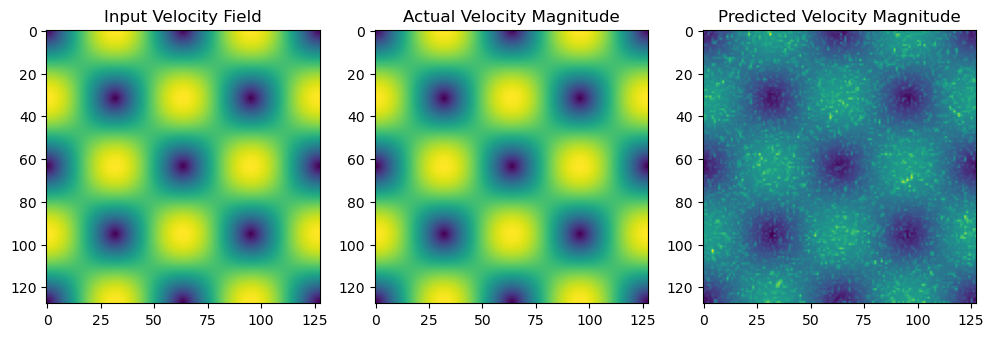

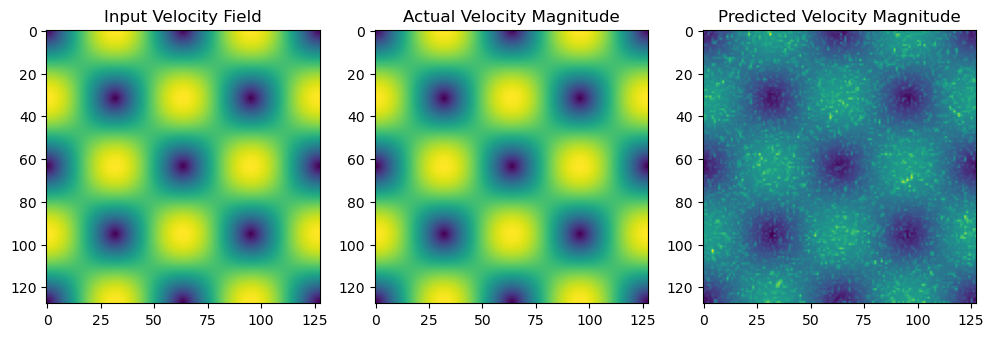

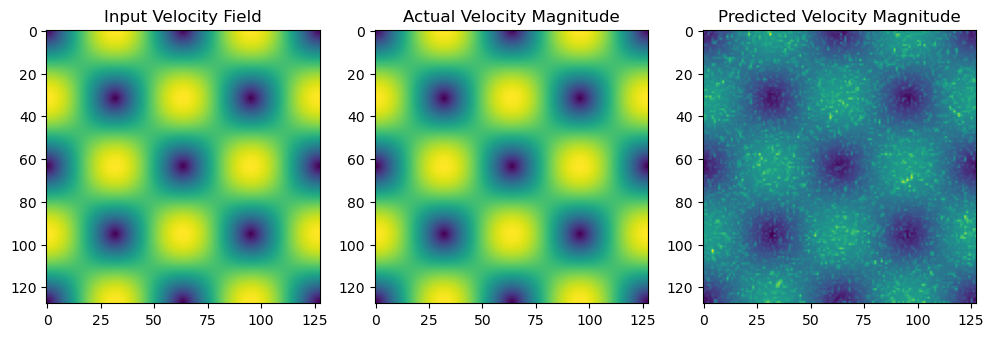

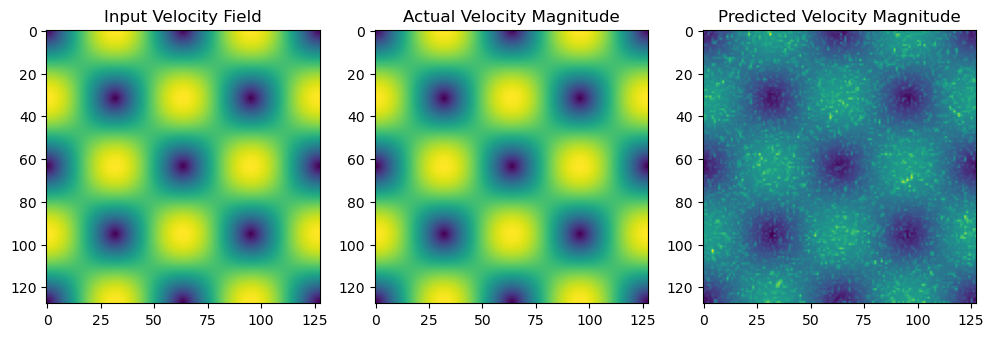

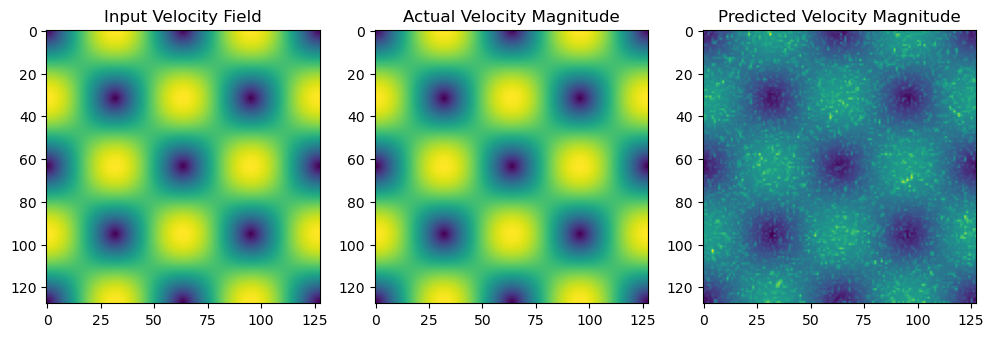

In [ ]:
num_samples_to_plot = 5
for i in range(num_samples_to_plot):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.title('Input Velocity Field')
    plt.imshow(np.sqrt(test_velocity_fields[i, 0]**2 + test_velocity_fields[i, 1]**2), cmap='viridis')
    
    plt.subplot(1, 3, 2)
    plt.title('Actual Velocity Magnitude')
    plt.imshow(actual_velocity_fields[i, 0, :, :], cmap='viridis')
    
    plt.subplot(1, 3, 3)
    plt.title('Predicted Velocity Magnitude')
    plt.imshow(predicted_velocity_fields[i,  :, :], cmap='viridis')
    
    plt.show()

上面尝试有错误

## 模型A训练

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义模型
class MultiOutputModel(nn.Module):
    def __init__(self):
        super(MultiOutputModel, self).__init__()
        self.shared_fc1 = nn.Linear(4096, 8192)
        self.shared_fc2 = nn.Linear(8192, 16384)
        
        self.fc_a = nn.Linear(16384, 4096)
        self.fc_b = nn.Linear(16384, 4096)
        self.fc_c = nn.Linear(16384, 4096)
        self.fc_d = nn.Linear(16384, 4096)
        
    def forward(self, x):
        x = torch.relu(self.shared_fc1(x))
        x = torch.relu(self.shared_fc2(x))
        
        a = self.fc_a(x)
        b = self.fc_b(x)
        c = self.fc_c(x)
        d = self.fc_d(x)
        
        return a, b, c, d

# 创建模型实例
model = MultiOutputModel()

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 生成一些随机训练数据
X_train = torch.randn(1000, 4096)
Y_train_a = torch.randn(1000, 4096)
Y_train_b = torch.randn(1000, 4096)
Y_train_c = torch.randn(1000, 4096)
Y_train_d = torch.randn(1000, 4096)

# 训练模型
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        targets_a = Y_train_a[i:i+batch_size]
        targets_b = Y_train_b[i:i+batch_size]
        targets_c = Y_train_c[i:i+batch_size]
        targets_d = Y_train_d[i:i+batch_size]
        
        # 前向传播
        outputs_a, outputs_b, outputs_c, outputs_d = model(inputs)
        loss_a = criterion(outputs_a, targets_a)
        loss_b = criterion(outputs_b, targets_b)
        loss_c = criterion(outputs_c, targets_c)
        loss_d = criterion(outputs_d, targets_d)
        loss = loss_a + loss_b + loss_c + loss_d
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 测试模型
model.eval()
new_vector = torch.randn(1, 4096)
with torch.no_grad():
    generated_a, generated_b, generated_c, generated_d = model(new_vector)

print(generated_a.shape)  # 应为 torch.Size([1, 4096])
print(generated_b.shape)  # 应为 torch.Size([1, 4096])
print(generated_c.shape)  # 应为 torch.Size([1, 4096])
print(generated_d.shape)  # 应为 torch.Size([1, 4096])


Epoch [1/10], Loss: 4.0038
Epoch [2/10], Loss: 4.0007
Epoch [3/10], Loss: 3.9982
Epoch [4/10], Loss: 3.9959
Epoch [5/10], Loss: 3.9934
Epoch [6/10], Loss: 3.9914
Epoch [7/10], Loss: 3.9895
Epoch [8/10], Loss: 3.9878
Epoch [9/10], Loss: 3.9864
Epoch [10/10], Loss: 3.9851
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
